In [16]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn.functional as F
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
class QAC_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    def __init__(self,
                 ac_network:torch.nn, # The shared network
                 optimizer:torch.optim,
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        self.device = device
        self.ac_network = ac_network
        self.optimizer = optimizer                
        self.gamma = gamma
        
    def get_action(self, obs:np.ndarray) -> Tuple[int, torch.tensor]:        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        dist,_ = self.ac_network(obs)
        dist = F.softmax(dist, dim = 0) 
        action_probs = torch.distributions.Categorical(dist)
        picked_action = action_probs.sample()
        log_prob = action_probs.log_prob(picked_action)
               
        return picked_action.item(), log_prob
    
    def train_policy(self,
                     obs:np.ndarray,
                     action:int,
                     log_prob:torch.tensor,
                     reward:float,
                     next_obs:np.ndarray,
                     next_action:int,
                     done:bool
                     ) -> None:
        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        next_obs = torch.tensor(next_obs, dtype = torch.float32).to(self.device)
        _, current_Q_list = self.ac_network(obs)
        current_Q = current_Q_list[action]
        _, next_Q_list = self.ac_network(next_obs)
        next_Q = next_Q_list[next_action]
        TD_target = reward + self.gamma * next_Q * (1 - float(done))
        
        policy_loss = -log_prob * current_Q
        value_loss =  F.mse_loss(current_Q, TD_target)
        loss = policy_loss + value_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    

In [18]:
class AC_Network(torch.nn.Module):
    """For convenience, we use the same network structure for both the policy and the value function.
        You can also use two different networks for them."""
    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(AC_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,64)
        self.pi = torch.nn.Linear(64,action_dim)
        self.q = torch.nn.Linear(64,action_dim)
                    
    def forward(self,x:torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = self.pi(x)
        q = self.q(x)
        
        return pi, q

In [19]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 lr:float = 0.001,
                 gamma:float = 0.9,
                 seed = 0,
                 my_device = "cpu"
                 ) -> None:
        
        self.seed = seed
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device(my_device)
    
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n
        ac_network = AC_Network(obs_dim,action_dim).to(self.device)
        optimizer = torch.optim.Adam(ac_network.parameters(),lr=lr)
        self.agent = QAC_Agent(ac_network = ac_network,
                               optimizer = optimizer,
                               gamma = gamma,
                               device = self.device)
        
        self.episode_total_rewards = np.zeros(self.episode_num)
        self.index_episode = 0    
        
    def train_episode(self,is_render:bool=False) -> float:
        total_reward = 0
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action, log_prob = self.agent.get_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            next_action, _ = self.agent.get_action(next_obs)
            self.agent.train_policy(obs, action, log_prob, reward, next_obs, next_action, done)
            total_reward += reward 
            obs = next_obs
            if is_render:
                self.env.render()
                                
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
        
        return total_reward
    
    def train(self) -> None:      
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%100 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward))
                
                
                
    def plotting(self,smoothing_window:int = 100) -> None:
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()

c:\Users\gemin\miniconda3\envs\pytorch\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Episode 0: Total Reward = 11.00
Episode 100: Total Reward = 11.00
Episode 200: Total Reward = 11.00
Episode 300: Total Reward = 11.00
Episode 400: Total Reward = 11.00
Episode 500: Total Reward = 11.00
Episode 600: Total Reward = 11.00
Episode 700: Total Reward = 11.00
Episode 800: Total Reward = 11.00
Episode 900: Total Reward = 11.00


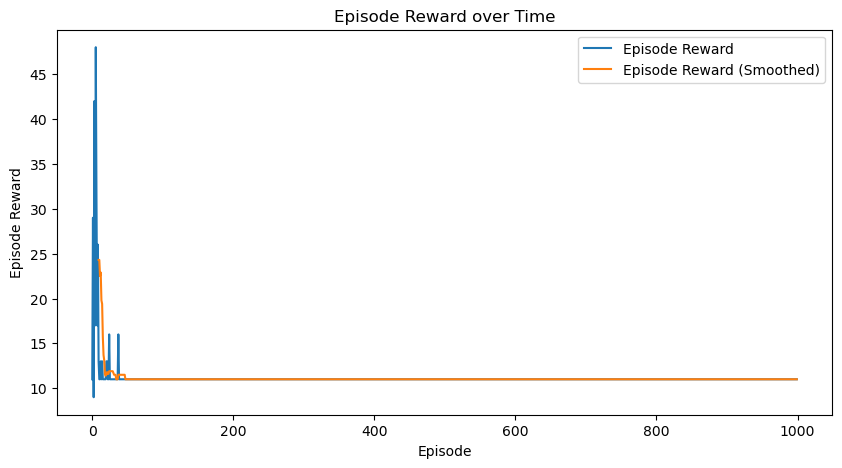

In [20]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        lr = 1e-3,
                        gamma = 0.98,
                        seed = 0,
                        my_device = "cpu" 
                        )
    Manger.train()
    Manger.plotting(smoothing_window=10)